In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import pandas as pd
class LogisticRegression:
    def __init__(self, learning_rate=0.001, n_iters=1000, l2_lambda=0.01, patience=100, alpha=0.7):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.l2_lambda = l2_lambda  # L2 regularization parameter
        self.patience = patience  # Early stopping patience
        self.alpha = alpha  # Weighting factor for the average
        self.weights = None
        self.bias = None
        self.losses = []  # For training loss
        self.val_losses = []  # For validation loss
        self.train_accuracies = []  # To track training accuracy
        self.test_accuracies = []   # To track testing accuracy
        self.weighted_accuracies = []  # To store weighted accuracies

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def compute_loss(self, y_true, y_pred):
        epsilon = 1e-9
        # binary cross-entropy loss with L2 regularization
        loss = -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))
        # L2 regularization penalty
        loss += self.l2_lambda * np.sum(self.weights**2)
        return loss

    def feed_forward(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self._sigmoid(z)

    def fit(self, X_train, y_train, X_test, y_test):
        n_samples, n_features = X_train.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        best_test_accuracy = 0
        epochs_without_improvement = 0

        for epoch in range(self.n_iters):
            # Training phase
            A_train = self.feed_forward(X_train)
            self.losses.append(self.compute_loss(y_train, A_train))  # Add training loss

            # Validation loss
            A_val = self.feed_forward(X_test)
            val_loss = self.compute_loss(y_test, A_val)
            self.val_losses.append(val_loss)  # Add validation loss

            dz = A_train - y_train
            dw = (1 / n_samples) * np.dot(X_train.T, dz) + 2 * self.l2_lambda * self.weights
            db = (1 / n_samples) * np.sum(dz)
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            # training accuracy
            train_predictions = (A_train > .2).astype(int)
            train_accuracy = np.mean(train_predictions == y_train)
            self.train_accuracies.append(train_accuracy)

            # testing accuracy
            A_test = self.feed_forward(X_test)
            test_predictions = (A_test > .2).astype(int)
            test_accuracy = np.mean(test_predictions == y_test)
            self.test_accuracies.append(test_accuracy)

            # weighted average of training and testing accuracies
            weighted_accuracy = self.alpha * train_accuracy + (1 - self.alpha) * test_accuracy
            self.weighted_accuracies.append(weighted_accuracy)

            # Early Stopping: Stop if test accuracy doesn't improve
            if test_accuracy > best_test_accuracy:
                best_test_accuracy = test_accuracy
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= self.patience:
                print(f"Early stopping at epoch {epoch}")
                break

            # Learning rate scheduler:Reduce learning rate if the test accuracy hasn't improved
            if epochs_without_improvement % 500 == 0 and epochs_without_improvement != 0:
                self.lr *= 0.5  # Reduce the learning rate by half

    def confusion_matrix(self, y_true, y_pred):
        TP = np.sum((y_true == 1) & (y_pred == 1))
        TN = np.sum((y_true == 0) & (y_pred == 0))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        FN = np.sum((y_true == 1) & (y_pred == 0))
        return np.array([[TN, FP], [FN, TP]]), TP, TN, FP, FN

    def evaluate(self, y_true, y_pred):
        cm, TP, TN, FP, FN = self.confusion_matrix(y_true, y_pred)
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        return cm, accuracy, precision, recall, f_score

    def predict(self, X):
        return (self.feed_forward(X) > 0.5).astype(int)

# # dataset
# dataset = datasets.load_breast_cancer()
# X, y = dataset.data, dataset.target

# # Scaling
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# # Train-Test Split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# # Logistic Regression model
# regressor = LogisticRegression(learning_rate=0.1, n_iters=500, l2_lambda=0.001, patience=1000, alpha=0.07)
# regressor.fit(X_train, y_train, X_test, y_test)

# # Make predictions
# predictions = regressor.predict(X_test)
# cm, accuracy, precision, recall, f_score = regressor.evaluate(y_test, predictions)

# # Print results
# print("Test accuracy: {:.3f}".format(accuracy))
# print("Confusion Matrix:\n", cm)
# print("Precision: {:.3f}".format(precision))
# print("Recall: {:.3f}".format(recall))
# print("F1 Score: {:.3f}".format(f_score))

# # Plot Confusion Matrix
# plt.figure(figsize=(6,5))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()

# # Plot Training and Validation Loss
# plt.figure(figsize=(8, 6))
# plt.plot(range(1, len(regressor.losses) + 1), regressor.losses, label="Training Loss", color="blue")
# plt.plot(range(1, len(regressor.val_losses) + 1), regressor.val_losses, label="Validation Loss", color="red")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Training and Validation Loss over Epochs")
# plt.legend()
# plt.show()

# # Plot Training, Testing, and Weighted Accuracy
# plt.figure(figsize=(8, 6))
# plt.plot(range(1, len(regressor.train_accuracies) + 1), regressor.train_accuracies, label="Training Accuracy", color="blue")
# plt.plot(range(1, len(regressor.test_accuracies) + 1), regressor.test_accuracies, label="Testing Accuracy", color="red")
# plt.plot(range(1, len(regressor.weighted_accuracies) + 1), regressor.weighted_accuracies, label="Weighted Accuracy", color="green")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.title("Training, Testing, and Weighted Accuracy over Epochs")
# plt.legend()
# plt.show()

# # ROC Curve
# fpr, tpr, thresholds = roc_curve(y_test, regressor.feed_forward(X_test))
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})", color="blue")
# plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("Receiver Operating Characteristic (ROC) Curve")
# plt.legend(loc="lower right")
# plt.show()

In [2]:
pwd

'/home/pawan/Downloads/Data_science/SCRATCH'

In [3]:
df = pd.read_csv('/home/pawan/Downloads/Data_science/SCRATCH/healthcare-dataset-stroke-data.xls')


In [4]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [6]:
df.dropna(inplace=True)

In [7]:
df['stroke'].value_counts()

0    4700
1     209
Name: stroke, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4909 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4909 non-null   int64  
 1   gender             4909 non-null   object 
 2   age                4909 non-null   float64
 3   hypertension       4909 non-null   int64  
 4   heart_disease      4909 non-null   int64  
 5   ever_married       4909 non-null   object 
 6   work_type          4909 non-null   object 
 7   Residence_type     4909 non-null   object 
 8   avg_glucose_level  4909 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     4909 non-null   object 
 11  stroke             4909 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 498.6+ KB


In [9]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()

# Apply LabelEncoder to all object (categorical) columns
df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).apply(lb.fit_transform)

print(df)

         id  gender   age  hypertension  heart_disease  ever_married  \
0      9046       1  67.0             0              1             1   
2     31112       1  80.0             0              1             1   
3     60182       0  49.0             0              0             1   
4      1665       0  79.0             1              0             1   
5     56669       1  81.0             0              0             1   
...     ...     ...   ...           ...            ...           ...   
5104  14180       0  13.0             0              0             0   
5106  44873       0  81.0             0              0             1   
5107  19723       0  35.0             0              0             1   
5108  37544       1  51.0             0              0             1   
5109  44679       0  44.0             0              0             1   

      work_type  Residence_type  avg_glucose_level   bmi  smoking_status  \
0             2               1             228.69  36.6   

In [10]:
X=df.drop(columns='stroke').values
y=df['stroke'].values

Test accuracy: 0.956
Confusion Matrix:
 [[939   0]
 [ 43   0]]
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


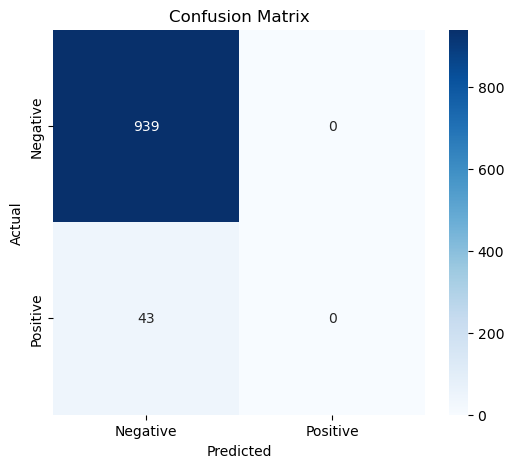

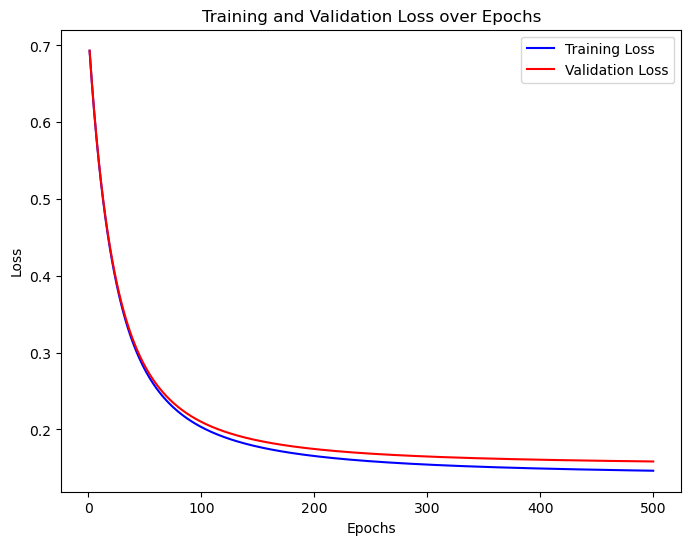

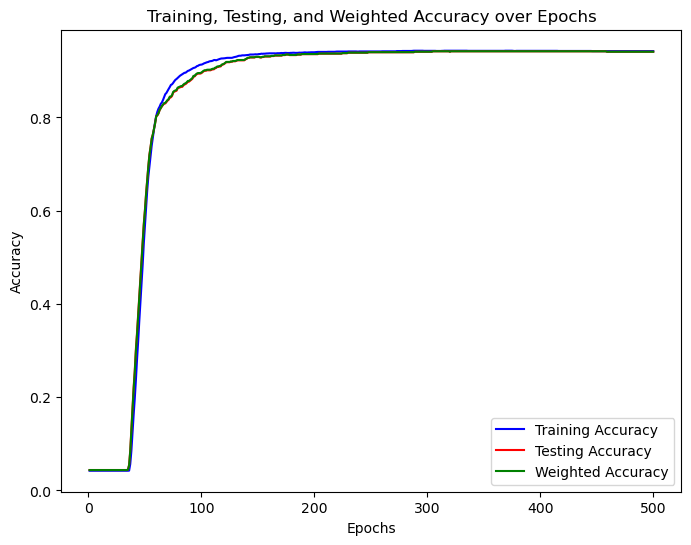

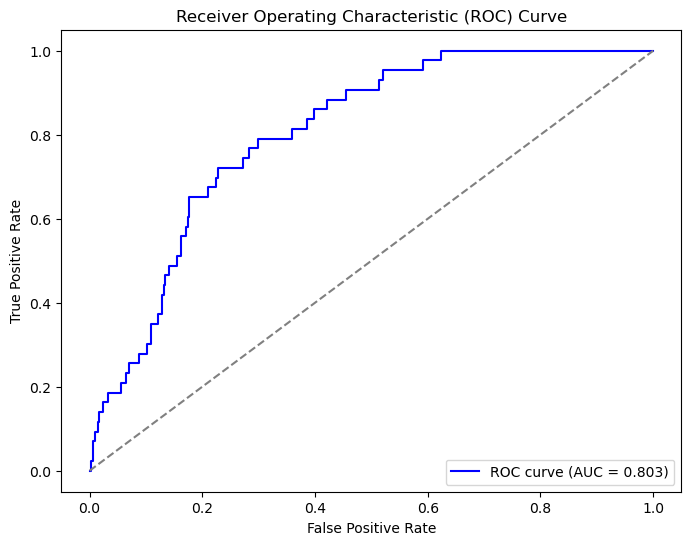

In [11]:
# Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Logistic Regression model
regressor = LogisticRegression(learning_rate=0.1, n_iters=500, l2_lambda=0.001, patience=1000, alpha=0.07)
regressor.fit(X_train, y_train, X_test, y_test)

# Make predictions
predictions = regressor.predict(X_test)
cm, accuracy, precision, recall, f_score = regressor.evaluate(y_test, predictions)

# Print results
print("Test accuracy: {:.3f}".format(accuracy))
print("Confusion Matrix:\n", cm)
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1 Score: {:.3f}".format(f_score))

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(regressor.losses) + 1), regressor.losses, label="Training Loss", color="blue")
plt.plot(range(1, len(regressor.val_losses) + 1), regressor.val_losses, label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.savefig("training_validation_loss.png")
plt.show()

# Plot Training, Testing, and Weighted Accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(regressor.train_accuracies) + 1), regressor.train_accuracies, label="Training Accuracy", color="blue")
plt.plot(range(1, len(regressor.test_accuracies) + 1), regressor.test_accuracies, label="Testing Accuracy", color="red")
plt.plot(range(1, len(regressor.weighted_accuracies) + 1), regressor.weighted_accuracies, label="Weighted Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training, Testing, and Weighted Accuracy over Epochs")
plt.legend()
plt.savefig("accuracy_plot.png")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, regressor.feed_forward(X_test))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})", color="blue")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.savefig("roc_curve.png")
plt.show()